https://sorabatake.jp/11731/

In [1]:
import numpy as np 
import os
import random 
# from PIL import Image, ImageOps 
from sklearn.metrics import accuracy_score 
import glob 
import matplotlib.pyplot as plt 
from mymodule import myfunc as mf
%matplotlib inline

PATH0 = glob.glob("../snap/density/05/*")#コネクションなし
PATH1 = glob.glob("../snap/density/13/*")#コネクションありに変える
PATH0TEST = glob.glob("../snap/density/03/*")
PATH1TEST = glob.glob("../snap/density/10/*")
ALTIMAGES0 = "../imgout/MLtest/0/"
ALTIMAGES1 = "../imgout/MLtest/1/"
def compress(array, LEVEL=10):
    return mf.convolute(array,mf.ave_carnel(LEVEL), stride = LEVEL)
temp = compress(mf.load(mf.gen_snap_path("density",1,1),z=3))
IMGSHAPE = temp.shape
print(IMGSHAPE)

np.random.seed(0) 
 #乱数のシードの設定

result   Y,X: 102 51
original Y,X: (1025, 513)
(102, 51)


# テストデータと訓練データを分ける


# 水増し

In [26]:
#リコネクションがない画像ファイルのパスのリストを取得
files = PATH0

#出力ディレクトリのパス
temp_output_dir = ALTIMAGES0

#ランダムな領域の切り取りを行う関数
def random_crop(imagearay, size=0.8):
    height, width, _ = imagearay.shape
    crop_size = int(min(height, width) * size)

    top = np.random.randint(0, height - crop_size)
    left = np.random.randint(0, width - crop_size)
    bottom = top + crop_size
    right = left + crop_size
    imagearay = imagearay[top:bottom, left:right,:]
    #motonosaizunimoosu
    return imagearay

def altarray_save(item):
    img = mf.load(item, z=3)
    file_name = os.path.basename(item)
    
    img_flip = np.flipud(img) # 画像の上下反転
    np.save(temp_output_dir + "flip_" + file_name , img_flip) # 画像保存
        
    img_mirror = np.fliplr(img) # 画像の左右反転
    np.save(temp_output_dir + "mirr_" + file_name , img_mirror) # 画像保存
            
    img_T = img.T # 画像の左右反転
    np.save(temp_output_dir + "trns_" + file_name , img_mirror) # 画像保存
    
    # img_crop = random_crop(img) # 画像の切り取り
    # img_crop = img_crop.resize((256, 256)) # 元のサイズに戻す
    # img_crop.save(temp_output_dir + file_name + "_crop.png") # 画像保存
 
for item in files:
    
    altarray_save(item)

In [27]:
#リコネクションがある画像ファイルのパスのリストを取得
files = PATH1

#出力ディレクトリのパス
temp_output_dir = ALTIMAGES1

for item in files:
    altarray_save(item)


# 読み込み

In [2]:
# 訓練データ
num_of_data_clear = len(glob.glob(ALTIMAGES0+"*")) # リコネクションがない画像の枚数
num_of_data_cloudy = len(glob.glob(ALTIMAGES1+"*")) # リコネクションがある画像の枚数
num_of_data_total = num_of_data_clear + num_of_data_cloudy # 学習データの全枚数

N_col = IMGSHAPE[0]*IMGSHAPE[1]*1 # 行列の列数
X_train = np.zeros((num_of_data_total, N_col)) # 学習データ格納のためゼロ行列生成
y_train = np.zeros((num_of_data_total)) # 学習データに対するラベルを格納するためのゼロ行列生成

# リコネクションがない画像を行列に読み込む
path_list = glob.glob(ALTIMAGES0+"*") 
i_count = 0

def load_regularize(item):
    type = item[:-4]
    print(item)
    if type == ".npy":
        im = np.load(item)
    elif type == ".npz":
        print("npz doesnot supported")
        return
    else:
        im = mf.load(item, z=3)
    img_resize = compress(im)
    return ((img_resize - min(img_resize.flat)) / max(img_resize.flat)).flat # 正規化

for item in path_list:
    X_train[i_count,:] = load_regularize(item)
    y_train[i_count] = 0 # リコネクションがないことを表すラベル
    i_count += 1
  
# リコネクションがある画像を行列に読み込む
path_list = glob.glob(ALTIMAGES1+"*") 

for item in path_list:
    X_train[i_count,:] = load_regularize(item)
    y_train[i_count] = 1 # リコネクションがあることを表すラベル
    i_count += 1

../imgout/MLtest/0\flip_density.01.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\flip_density.02.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\flip_density.03.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\flip_density.04.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\flip_density.05.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\flip_density.06.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\flip_density.07.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\flip_density.08.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\flip_density.09.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\flip_density.10.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\flip_density.11.05.npy
result   Y,X: 102 51
original Y,X: (1025, 513)
../imgout/MLtest/0\fl

In [3]:
# テストデータ
num_of_data_clear = len(PATH0TEST) # リコネクションがない画像の枚数
num_of_data_cloudy = len(PATH1TEST) # リコネクションがある画像の枚数
num_of_data_total = num_of_data_clear + num_of_data_cloudy # テストデータの全枚数

N_col = IMGSHAPE[0]*IMGSHAPE[1]*1 # 行列の列数(RGBなら*3)
X_test = np.zeros((num_of_data_total, N_col)) # テストデータ格納のためゼロ行列生成
y_test = np.zeros(num_of_data_total) # テストデータに対するラベルを格納するためのゼロ行列生成

# リコネクションがない画像を行列に読み込む
path_list = PATH0TEST 
i_count = 0
for item in path_list:

    X_test[i_count,:] = load_regularize(item)
    y_test[i_count] = 0 # リコネクションがないことを表すラベル
    i_count += 1

# リコネクションがある画像を行列に読み込む
path_list = PATH1TEST

for item in path_list:
    X_test[i_count,:] = load_regularize(item)
    y_test[i_count] = 1 # リコネクションがあることを表すラベル
    i_count += 1 

../snap/density/03\density.01.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.02.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.03.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.04.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.05.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.06.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.07.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.08.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.09.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.10.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.11.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.12.03
result   Y,X: 102 51
original Y,X: (1025, 513)
../snap/density/03\density.13.03
result 

# 学習

# PCA

In [4]:
from sklearn.decomposition import PCA
N_dim =  100 # 49152(=128×128×3)の列を100列に落とし込む

pca = PCA(n_components=N_dim, random_state=0)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))

累積寄与率: 1.0


# Linear SVC

In [31]:
from sklearn.svm import LinearSVC # ライブラリのインポート

model = LinearSVC(C=0.3, random_state=0) # インスタンスを生成

model.fit(X_train_pca, y_train) # モデルの学習

# 学習データに対する精度
print("Train :", model.score(X_train_pca,  y_train)) 

# テストデータに対する精度
print("Test :", model.score(X_test_pca, y_test)) 

Train : 0.6684782608695652
Test : 0.4959349593495935


# KNeighbors Classifier

In [32]:
from sklearn.neighbors import KNeighborsClassifier # ライブラリのインポート

n_neighbors = int(np.sqrt(6000))  # kの設定

model = KNeighborsClassifier(n_neighbors = n_neighbors)  
model.fit(X_train_pca, y_train) # モデルの学習
    
# 精度
print("Train :", model.score(X_train_pca, y_train))
print("Test :", model.score(X_test_pca, y_test))

Train : 0.33152173913043476
Test : 0.5040650406504065


# 非線形SVC RBFカーネル

In [33]:

from sklearn.svm import SVC # ライブラリのインポート

model = SVC(C=0.3, kernel='rbf', random_state=0) # インスタンスを生成 

model.fit(X_train_pca, y_train) # モデルの学習

# 精度
print("Train :", model.score(X_train_pca,  y_train))
print("Test :", model.score(X_test_pca, y_test))

Train : 0.6684782608695652
Test : 0.4959349593495935


# XGBoost

In [34]:
import xgboost as xgb # ライブラリのインポート

model = xgb.XGBClassifier(n_estimators=80, max_depth=4, gamma=3) # インスタンスの生成
           
model.fit(X_train_pca, y_train) # モデルの学習
   
# 精度
print("Train :", model.score(X_train_pca,  y_train))
print("Test :", model.score(X_test_pca, y_test))

Train : 1.0
Test : 0.4959349593495935


# まとめ

In [35]:
from sklearn.model_selection import *
train_sizes = np.array([0.1, 0.33, 0.55, 0.78, 1. ]) # 用いる学習データの割合を全体の0.1〜1まで変化させる

train_sizes, train_scores_linearSVC, test_scores_linearSVC = learning_curve(
    model_linearSVC, X_train_pca, y_train, cv=5, train_sizes=train_sizes, random_state=0, shuffle=True
    ) # 様々学習データ数に対して、モデルを学習・評価する。

# 各学習データ数の場合について学習用データと検証用データに対する精度を求める。
train_scores_mean_linearSVC = np.mean(train_scores_linearSVC, axis=1)
train_scores_std_linearSVC = np.std(train_scores_linearSVC, axis=1)
validation_scores_mean_linearSVC = np.mean(validation_scores_linearSVC, axis=1)
validation_scores_std_linearSVC = np.std(validation_scores_linearSVC, axis=1)

NameError: name 'model_linearSVC' is not defined

NameError: name 'train_scores_mean_linearSVC' is not defined

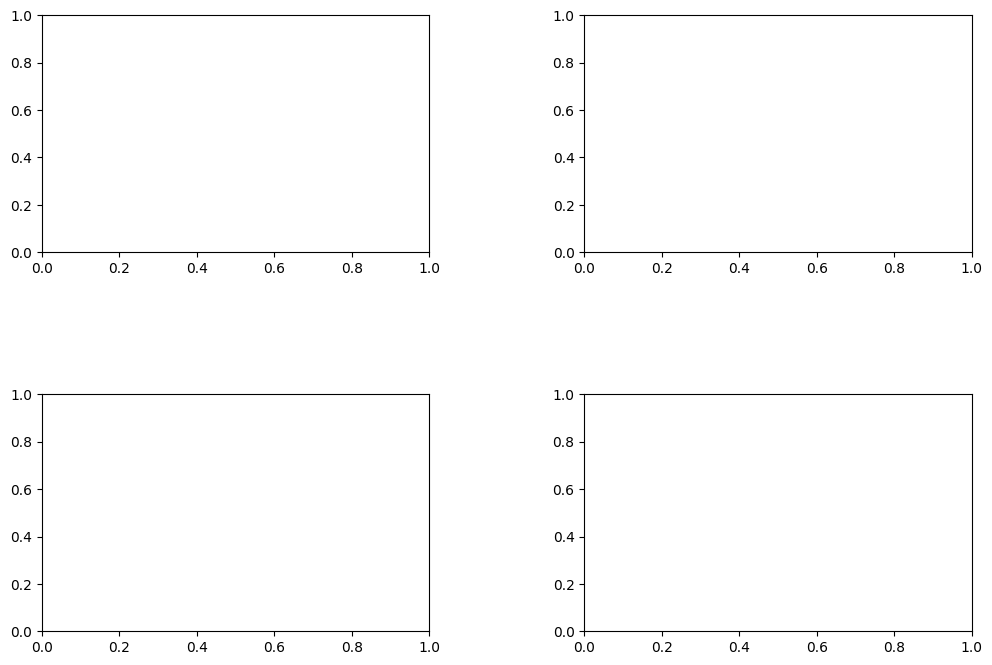

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Linear SVCの学習曲線
ax[0,0].plot(train_sizes, train_scores_mean_linearSVC, 'o-', color="r", label="Training score")
ax[0,0].plot(train_sizes, validation_scores_mean_linearSVC, 'o-', color="g", label="Test score")

ax[0, 0].set_title('Linear SVC')
ax[0, 0].set_xlabel('Number of Taining data')
ax[0, 0].set_ylabel('Accyracy')
ax[0,0].set_ylim(0.4, 0.8)
ax[0,0].legend(loc="best")

# kNNの学習曲線
ax[1,0].plot(train_sizes, train_scores_mean_kNN, 'o-', color="r", label="Training score")
ax[1,0].plot(train_sizes, validation_scores_mean_kNN, 'o-', color="g", label="Test score")

ax[1, 0].set_title('k-NN')
ax[1, 0].set_xlabel('Number of Taining data')
ax[1, 0].set_ylabel('Accuracy')
ax[1,0].set_ylim(0.5, 0.7)
ax[1,0].legend(loc="best")

# 非線形SVCの学習曲線
ax[0,1].plot(train_sizes, train_scores_mean_nonlinearSVC, 'o-', color="r", label="Training score")
ax[0,1].plot(train_sizes, validation_scores_mean_nonlinearSVC, 'o-', color="g", label="Test score")
ax[0, 1].set_title('non-linear SVC')
ax[0, 1].set_xlabel('Number of Taining data')
ax[0, 1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.7, 0.9)
ax[0,1].legend(loc="best")

# XGBoostの学習曲線
ax[1,1].plot(train_sizes, train_scores_mean_xgb, 'o-', color="r", label="Training score")
ax[1,1].plot(train_sizes, validation_scores_mean_xgb, 'o-', color="g", label="Test score")

ax[1, 1].set_title('XGBoost')
ax[1, 1].set_xlabel('Number of Taining data')
ax[1, 1].set_ylabel('Accuracy')
ax[1,1].set_ylim(0.7, 1.0)
ax[1,1].legend(loc="best")